In [1]:
import pandas as pd

train_df = pd.read_csv('A3_task1_data_files/train.csv', sep='\t')
dev_df = pd.read_csv('A3_task1_data_files/dev.csv', sep='\t')

dev_df.rename(columns={'setence1': 'sentence1'}, inplace=True)

In [2]:
# Check for null values in both dataframes
print('Train null values:')
print(train_df.isnull().sum())

print('Dev null values:')
print(dev_df.isnull().sum())

Train null values:
score        0
sentence1    0
sentence2    3
dtype: int64
Dev null values:
score        0
sentence1    0
sentence2    2
dtype: int64


In [3]:
# Drop rows with null values
train_df.dropna(inplace=True)
dev_df.dropna(inplace=True)

# Check for null values in both dataframes
print('Train null values:')
print(train_df.isnull().sum())

print('Dev null values:')
print(dev_df.isnull().sum())

Train null values:
score        0
sentence1    0
sentence2    0
dtype: int64
Dev null values:
score        0
sentence1    0
sentence2    0
dtype: int64


In [4]:
print(train_df.shape)
print(dev_df.shape)

(5708, 3)
(1468, 3)


In [5]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from transformers import BertTokenizer
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


/home/medhahira/miniconda3/envs/A3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/medhahira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/medhahira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/medhahira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/medhahira/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Punctuation removal
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])

    return lemmatized_text

In [7]:
class Task1A_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text1 = str(self.dataframe.iloc[idx]['sentence1'])
        text2 = str(self.dataframe.iloc[idx]['sentence2'])

        sentence1 = preprocess_text(text1)
        sentence2 = preprocess_text(text2)

        score = self.dataframe.iloc[idx]['score']

        # Tokenize the pair of sentences to get the token ids, attention masks, and token type ids
        encoding = self.tokenizer.encode_plus(
            sentence1, sentence2,
            add_special_tokens=True, #cls and sep
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'labels': torch.tensor(score, dtype=torch.float)
        }

In [8]:
# Assuming 'df' is your DataFrame
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize the dataset
train_dataset = Task1A_Dataset(train_df, tokenizer)
dev_dataset = Task1A_Dataset(dev_df, tokenizer)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=64, shuffle=False)

In [9]:
from transformers import BertModel
import torch
import torch.nn as nn

class BertForTextSimilarity(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertForTextSimilarity, self).__init__()
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add a linear layer for regression
        self.regression = nn.Linear(self.bert.config.hidden_size, 1)

        # Option to freeze BERT layers to prevent them from being updated during training
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Get the output from BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # The first token of every sequence is a special token ([CLS]) that contains the aggregate representation for classification tasks. We use it for regression here.
        cls_output = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)

        # Pass the [CLS] token's output through the regression layer
        score = self.regression(cls_output)  # Shape: (batch_size, 1)

        return score

In [10]:
model = BertForTextSimilarity()
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)  # Move model to CUDA device if available
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

Using CUDA


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
mse_loss = torch.nn.MSELoss()

num_epochs = 3 

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()  
    train_loss = 0
    for batch in train_dataloader:
        # Forward pass
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        loss = mse_loss(outputs.squeeze(), inputs['labels'])

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Validation
    model.eval()  
    val_loss = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for batch in dev_dataloader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
            loss = mse_loss(outputs.squeeze(), inputs['labels'])
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_dataloader)
    avg_val_loss = val_loss / len(dev_dataloader)

    # Append the losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 1/3, Train Loss: 1.3841, Validation Loss: 0.6854


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 2/3, Train Loss: 0.5954, Validation Loss: 0.6711


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch 3/3, Train Loss: 0.4510, Validation Loss: 0.6678


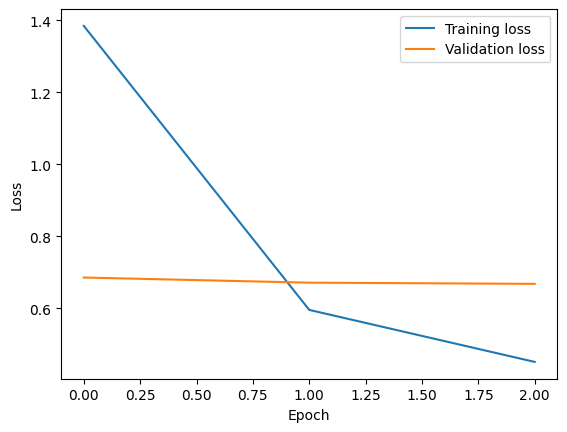

In [12]:
# Plot the training and validation losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Calculate similarity scores on the validation set

model.eval()  # Set the model to evaluation mode
predictions = []
labels = []

with torch.no_grad():  # No need to compute gradients during validation
    for batch in dev_dataloader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        predictions.extend(outputs.squeeze().tolist())
        labels.extend(inputs['labels'].tolist())

# Calculate Pearson correlation
from scipy.stats import pearsonr

correlation, p_value = pearsonr(labels, predictions)

print(f'Pearson Correlation: {correlation:.4f}, P-Value: {p_value:.4f}')

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Pearson Correlation: 0.8510, P-Value: 0.0000


In [14]:
# Save the model
torch.save(model.state_dict(), 'BERT_Setup1A.pt')